<a href="https://colab.research.google.com/github/arminnorouzi/machine_learning_course_UofA_MECE610/blob/main/L06_Transfer_Learning_with_TensorFlow_and_PyTorch/L06a_Transfer_Learning_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   # Transfer Learning with Tensorflow
   
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Tensorflow 2.8.2

   
   - **Objective:** Using pretrained model and perfrom different kinds of transfer learning
   

   
**Table of content:**

1. Introduction to Trasnfer Learning
2. Trasnfer Learning using Feature Extraction
3. Trasnfer Learning using Fine-tuning




# Introduction to Trasnfer Learning

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.


In other words, instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Using GPU is highly recommended in transfer learning.



In [1]:
# Are we using a GPU?
!nvidia-smi

Thu Sep  8 15:32:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Helper fucntions

In [2]:
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

# Trasnfer Learning using Feature Extraction

## Loading data

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")


--2022-09-08 15:32:37--  https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_10_percent.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/octet-stream]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  48.7MB/s    in 3.3s    

2022-09-08 15:32:41 (49.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images are we working with now?
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

### Creating data loaders

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks


[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.









In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  ''' This function is used to create tensorboard callback

  Arg:
      dir_name: overall logs directory
      experiment_name: particular experiment
      current_timestamp: time the experiment started based on Python's datetime.datetime().now()
  '''
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In this section, pre trained model will import from [TensorFlow Hub](https://tfhub.dev/):

1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.


Finding model based on application in tfhub:

1. Go to [tfhub.dev](https://tfhub.dev/).
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on. 
5. The models listed are all models which could potentially be used for your problem.
6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear. 
  * The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
  * However, the tradeoff with larger numbers can mean they take longer to compute. 
7. Select EfficientNetB0 
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.
  * Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

Differnet types of transfer learning:

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 


2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 


3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).


> **Question:** *Why train only the top 2-3 layers in feature extraction?*

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.


In [7]:
import tensorflow_hub as hub
from tensorflow.keras import layers

### Resnet 50

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the `callbacks` parameter in the fit function.

In our case, we'll pass the `callbacks` parameter the `create_tensorboard_callback()` we created earlier with some specific inputs so we know what experiments we're running.

Let's keep this experiment short and train for 5 epochs.

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220908-153304
Epoch 1/5
24/24 [==============================] - 33s 775ms/step - loss: 1.8411 - accuracy: 0.3893 - val_loss: 1.1455 - val_accuracy: 0.6440
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8830 - accuracy: 0.7453 - val_loss: 0.8329 - val_accuracy: 0.7400
Epoch 3/5
24/24 [==============================] - 18s 778ms/step - loss: 0.6080 - accuracy: 0.8333 - val_loss: 0.7413 - val_accuracy: 0.7580
Epoch 4/5
24/24 [==============================] - 17s 739ms/step - loss: 0.4850 - accuracy: 0.8720 - val_loss: 0.7182 - val_accuracy: 0.7624
Epoch 5/5
24/24 [==============================] - 17s 737ms/step - loss: 0.3731 - accuracy: 0.9160 - val_loss: 0.6747 - val_accuracy: 0.7784



It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made in L04, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set **with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our `plot_loss_curves` function.

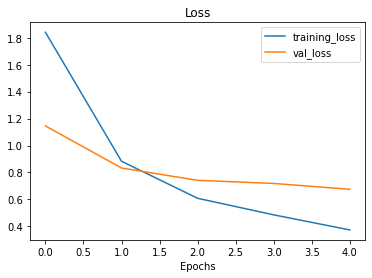

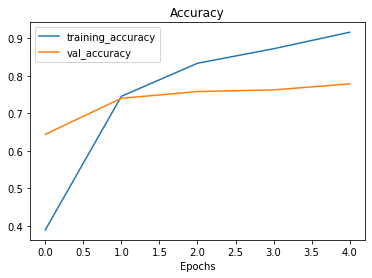

In [12]:
plot_loss_curves(resnet_history)

In [13]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### EfficientNetB0

In [14]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220908-153508
Epoch 1/5
24/24 [==============================] - 26s 743ms/step - loss: 1.9594 - accuracy: 0.3787 - val_loss: 1.4887 - val_accuracy: 0.6248
Epoch 2/5
24/24 [==============================] - 16s 696ms/step - loss: 1.3003 - accuracy: 0.6893 - val_loss: 1.1166 - val_accuracy: 0.7064
Epoch 3/5
24/24 [==============================] - 16s 702ms/step - loss: 1.0095 - accuracy: 0.7427 - val_loss: 0.9440 - val_accuracy: 0.7436
Epoch 4/5
24/24 [==============================] - 17s 714ms/step - loss: 0.8457 - accuracy: 0.7947 - val_loss: 0.8553 - val_accuracy: 0.7584
Epoch 5/5
24/24 [==============================] - 18s 756ms/step - loss: 0.7393 - accuracy: 0.8267 - val_loss: 0.7977 - val_accuracy: 0.7676


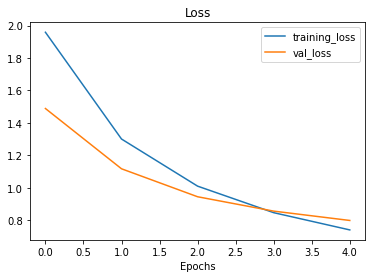

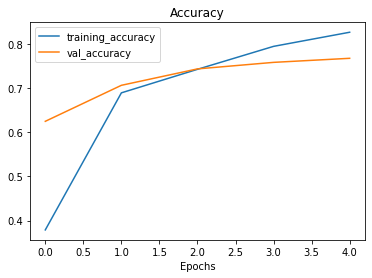

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


## Comparing models using TensorBoard

Alright, even though we've already compared the performance of our two models by looking at the accuracy scores. But what if you had more than two models? 

That's where an experiment tracking tool like [TensorBoard](https://www.tensorflow.org/tensorboard) (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to [TensorBoard.dev](https://tensorboard.dev/).

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.



### Uploading experiments to TensorBoard

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

In [21]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/2jpEI1v1SbW3IlqhMfDdTA/

[2022-09-08T15:43:39] Started scanning logdir.
[2022-09-08T15:43:41] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (4.3 MB)
[2022-09-08T15:43:41] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/2jpEI1v1SbW3IlqhMfDdTA/


Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description of the experiment
* `--one_shot` exits the TensorBoard uploader once uploading is finished


Every time you upload something to TensorBoad.dev you'll get a new experiment ID. The experiment ID will look something like this: https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/ (this is the actual experiment from this notebook).

If you upload the same directory again, you'll get a new experiment ID to go along with it.

This means to track your experiments, you may want to look into how you name your uploads. That way when you find them on TensorBoard.dev you can tell what happened during each experiment (e.g. "efficientnet0_10_percent_data").

### Listing experiments you've saved to TensorBoard

To see all of the experiments you've uploaded you can use the command:

```tensorboard dev list```

In [22]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/2jpEI1v1SbW3IlqhMfDdTA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   2jpEI1v1SbW3IlqhMfDdTA
	Created              2022-09-08 15:43:39 (15 seconds ago)
	Updated              2022-09-08 15:43:41 (13 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  4498181
Total: 1 experiment(s)


### Deleting experiments from TensorBoard

Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

In [23]:
# Delete an experiment
!tensorboard dev delete --experiment_id 2jpEI1v1SbW3IlqhMfDdTA

Deleted experiment 2jpEI1v1SbW3IlqhMfDdTA.


In [24]:

# Check to see if experiments still exist
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


# Fine-tuning

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

This section includes:

- Using the Keras Functional API
- Data augmentation 
- Running a series of modelling experiments on Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

### Load dataset using keras preprocessing


One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

In [25]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent_keras = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent_keras = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Models


### Model 0:

Building a transfer learning model using the Keras Functional API

We are going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. (The EfficientNet models in the tf.keras.applications module do not require images to be normalized)
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [26]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")


16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)


In [27]:
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

After GlobalAveragePooling2D(): (None, 1280)


In [28]:
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent_keras,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent_keras),
                                 validation_data=test_data_10_percent_keras,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent_keras)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220908-154439
Epoch 1/5
24/24 [==============================] - 15s 264ms/step - loss: 1.9712 - accuracy: 0.3533 - val_loss: 1.4307 - val_accuracy: 0.6513
Epoch 2/5
24/24 [==============================] - 4s 162ms/step - loss: 1.1733 - accuracy: 0.7440 - val_loss: 0.9911 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8505 - accuracy: 0.8080 - val_loss: 0.8082 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6894 - accuracy: 0.8347 - val_loss: 0.7080 - val_accuracy: 0.8158
Epoch 5/5
24/24 [==============================] - 5s 183ms/step - loss: 0.5875 - accuracy: 0.8667 - val_loss: 0.6411 - val_accuracy: 0.8273


In [29]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

In [30]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

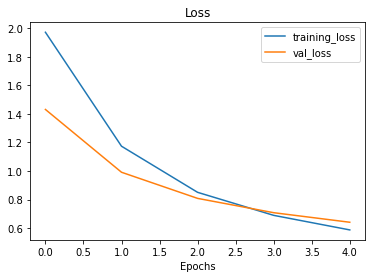

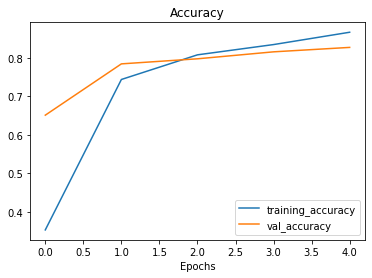

In [31]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.


### model 1
 Use feature extraction transfer learning on 1% of the training data with data augmentation.

In [32]:
# Download and unzip data
!wget https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-09-08 15:45:20--  https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_1_percent.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/octet-stream]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  63.7MB/s    in 2.0s    

2022-09-08 15:45:22 (63.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [33]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [34]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Adding data augmentation right into the model

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220908-154806
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.4299 - accuracy: 0.1000 - val_loss: 2.2001 - val_accuracy: 0.2039
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2319 - accuracy: 0.1429 - val_loss: 2.0808 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0314 - accuracy: 0.3143 - val_loss: 1.9581 - val_accuracy: 0.3586
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7995 - accuracy: 0.4714 - val_loss: 1.8675 - val_accuracy: 0.4293
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6567 - accuracy: 0.6286 - val_loss: 1.7885 - val_accuracy: 0.4753
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                  

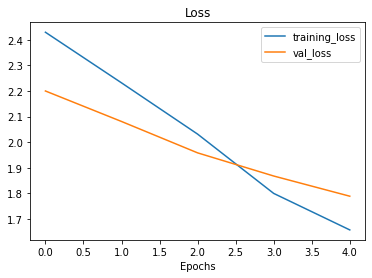

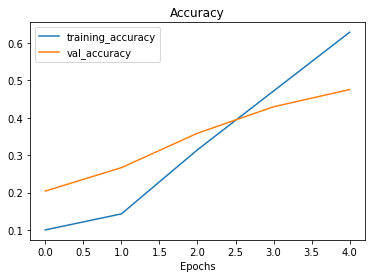

In [36]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

# Check out model summary
model_1.summary()

# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

### model 2
Use feature extraction transfer learning on 10% of the training data with data augmentation.

In [37]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [38]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [41]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220908-154838
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9781 - accuracy: 0.3520
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 340ms/step - loss: 1.9781 - accuracy: 0.3520 - val_loss: 1.4744 - val_accuracy: 0.6579
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 247ms/step - loss: 1.3687 - accuracy: 0.6640 - val_loss: 1.0692 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.7453
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 250ms/step - loss: 1.0699 - accuracy: 0.7453 - val_loss: 0.8675 - val_accuracy: 0.7829
Epo

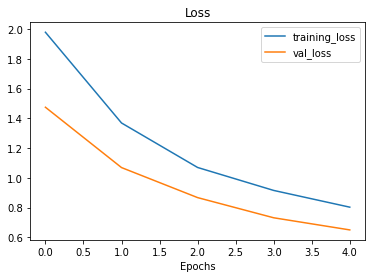

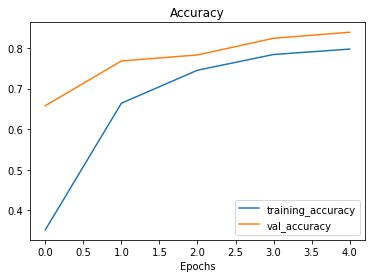

In [42]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

### model 3

Use fine-tuning transfer learning on 10% of the training data with data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.


In [43]:
# Layers in loaded model
model_2.layers

In [44]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [45]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [46]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [47]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  if layer.trainable:
    print(layer_number, layer.name, layer.trainable)

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

In [48]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [49]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  if layer.trainable:
    print(layer_number, layer.name, layer.trainable)

227 block7a_se_squeeze True
228 block7a_se_reshape True
229 block7a_se_reduce True
230 block7a_se_expand True
231 block7a_se_excite True
232 block7a_project_conv True
233 block7a_project_bn True
234 top_conv True
235 top_bn True
236 top_activation True


It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual

In [50]:
print(len(model_2.trainable_variables))

12


We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://keras.rstudio.com/reference/fit.html) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220908-154932
Epoch 5/10
24/24 [==============================] - 16s 317ms/step - loss: 0.7021 - accuracy: 0.7853 - val_loss: 0.5748 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 9s 349ms/step - loss: 0.5649 - accuracy: 0.8347 - val_loss: 0.5267 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 7s 246ms/step - loss: 0.5049 - accuracy: 0.8480 - val_loss: 0.4481 - val_accuracy: 0.8470
Epoch 8/10
24/24 [==============================] - 6s 228ms/step - loss: 0.4680 - accuracy: 0.8600 - val_loss: 0.4741 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 6s 218ms/step - loss: 0.4201 - accuracy: 0.8640 - val_loss: 0.4773 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 6s 233ms/step - loss: 0.3926 - accuracy: 0.8907 - val_loss: 0.4779 - val_accuracy: 0.8438


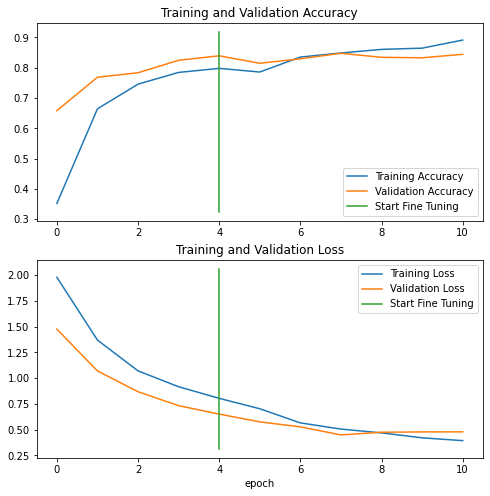

In [52]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

### model 4
 Use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [53]:
# Download and unzip 10 classes of data with all images
!wget https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-09-08 15:50:30--  https://gitlab.com/arminny/ml_course_datasets/-/raw/main/10_food_classes_all_data.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/octet-stream]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  65.5MB/s    in 8.7s    

2022-09-08 15:50:39 (56.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [54]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [55]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [56]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [57]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.6921 - accuracy: 0.8172


[0.6921055316925049, 0.8172000050544739]

In [58]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [59]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  if layer.trainable:
    print(layer_number, layer.name, layer.trainable)

227 block7a_se_squeeze True
228 block7a_se_reshape True
229 block7a_se_reduce True
230 block7a_se_expand True
231 block7a_se_excite True
232 block7a_project_conv True
233 block7a_project_bn True
234 top_conv True
235 top_bn True
236 top_activation True


In [60]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [61]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220908-155056
Epoch 5/10
235/235 [==============================] - 38s 129ms/step - loss: 0.7312 - accuracy: 0.7664 - val_loss: 0.4120 - val_accuracy: 0.8668
Epoch 6/10
235/235 [==============================] - 28s 117ms/step - loss: 0.5914 - accuracy: 0.8031 - val_loss: 0.4009 - val_accuracy: 0.8684
Epoch 7/10
235/235 [==============================] - 27s 113ms/step - loss: 0.5305 - accuracy: 0.8291 - val_loss: 0.3562 - val_accuracy: 0.8734
Epoch 8/10
235/235 [==============================] - 27s 111ms/step - loss: 0.4836 - accuracy: 0.8399 - val_loss: 0.3527 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 26s 109ms/step - loss: 0.4496 - accuracy: 0.8525 - val_loss: 0.3574 - val_accuracy: 0.8849
Epoch 10/10
235/235 [==============================] - 26s 108ms/step - loss: 0.4188 - accuracy: 0.8604 - val_loss: 0.3353 - val_accuracy: 0.8931


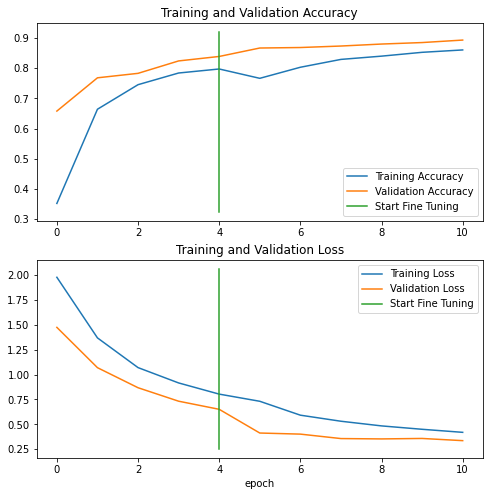

In [62]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

## Viewing our experiment data on TensorBoard

In [63]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/52ljO1lFRn6S5D1sK1ULTQ/

[2022-09-08T15:55:00] Started scanning logdir.
[2022-09-08T15:55:05] Total uploaded: 162 scalars, 0 tensors, 5 binary objects (4.1 MB)
[2022-09-08T15:55:05] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/52ljO1lFRn6S5D1sK1ULTQ/


In [64]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/52ljO1lFRn6S5D1sK1ULTQ/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   52ljO1lFRn6S5D1sK1ULTQ
	Created              2022-09-08 15:55:00 (1 minute ago)
	Updated              2022-09-08 15:55:05 (1 minute ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308795
Total: 1 experiment(s)


In [65]:
# Remove previous experiments
!tensorboard dev delete --experiment_id 52ljO1lFRn6S5D1sK1ULTQ

Deleted experiment 52ljO1lFRn6S5D1sK1ULTQ.


## References: 

* [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning)
* [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
* [fine-tuning a TensorFlow Hub model tutorial](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) 
* [experiment tracking with Weights & Biases](https://www.wandb.com/experiment-tracking)